# Attention Demo

<font color=red>注意：这里不使用d2l环境了</font>

使用多元的attention来做一些fitting的实验，前面的`13_attention_3_more.ipynb`可以看到最后的`Dot Product`生成的注意力图不太好，个人理解是数据的问题，于是这里打算生成一些数据来简单玩玩。

## Generate Spiral Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def generate_spiral_data(n_samples, n_classes, noise=0.5, rotate=2):
    X = np.zeros((n_samples * n_classes, 2))
    y = np.zeros(n_samples * n_classes, dtype='int')
    
    for j in range(n_classes):
        ix = range(n_samples * j, n_samples * (j + 1))
        r = np.linspace(0.0, 1, n_samples)
        factor = rotate * np.pi / n_classes
        t = np.linspace(j * factor, (j + 1) * factor, n_samples) + np.random.randn(n_samples) * noise
        X[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
        y[ix] = j
    
    return X, y

def plot_data(X, y, n_classes):
    plt.figure(figsize=(5, 5))
    for class_label in range(n_classes):
        plt.scatter(
            X[y == class_label, 0], 
            X[y == class_label, 1], 
            label=f'Class {class_label}'
        )
    plt.title('Spiral Data')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.legend()
    plt.show()



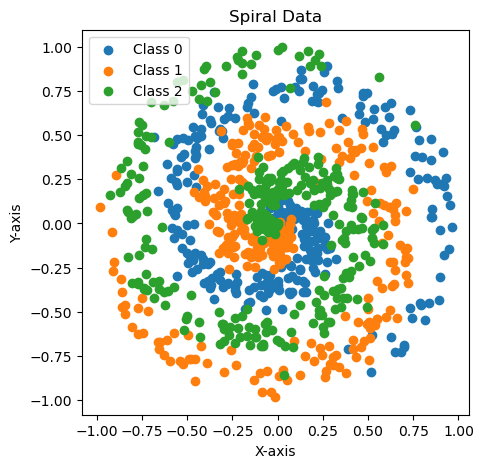

In [2]:
n_samples = 300
n_classes = 3
noise = 0.6
rotate = 8 # 为2时，多少类别都不会重叠

X, y = generate_spiral_data(n_samples, n_classes, noise, rotate)
plot_data(X, y, n_classes)

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [4]:
# 分割数据为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Use KNeighbors of sklearn

In [5]:
# 选择分类器（这里使用K近邻分类器）
k = 5  # 选择K值
clf = KNeighborsClassifier(n_neighbors=k)

# 训练分类器
clf.fit(X_train, y_train)

# 预测测试集
y_pred = clf.predict(X_test)

# 评估分类器性能
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 91.11%


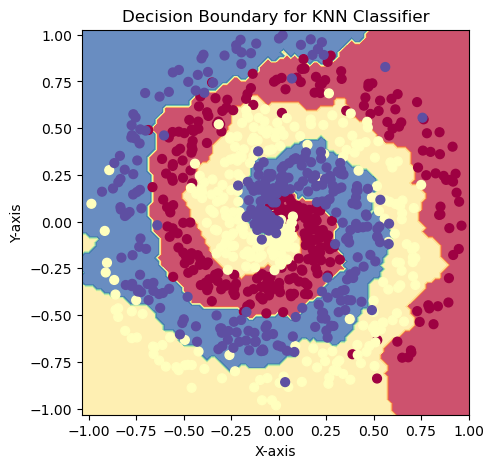

In [6]:
def plot_decision_boundary_sklearn(X, y, clf):
    h = 0.02
    x_min, x_max = X[:, 0].min() - .05, X[:, 0].max() + .05
    y_min, y_max = X[:, 1].min() - .05, X[:, 1].max() + .05
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # k近邻分类器预测
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.figure(figsize=(5, 5))
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("Decision Boundary for KNN Classifier")
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.show()

plot_decision_boundary_sklearn(X, y, clf)

## Use Nerual Network

In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

In [8]:
# Define a simple neural network model
class NeuralNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [9]:
# Convert numpy arrays to torch tensors
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).long()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).long()

In [10]:
input_dim = 2
hidden_dim = 64
output_dim = n_classes
model = NeuralNet(input_dim, hidden_dim, output_dim)

In [11]:
# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)


In [12]:
# Training the model
num_epochs = 1000
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [100/1000], Loss: 0.8415
Epoch [200/1000], Loss: 0.6064
Epoch [300/1000], Loss: 0.4554
Epoch [400/1000], Loss: 0.3786
Epoch [500/1000], Loss: 0.3320
Epoch [600/1000], Loss: 0.2977
Epoch [700/1000], Loss: 0.2727
Epoch [800/1000], Loss: 0.2542
Epoch [900/1000], Loss: 0.2392
Epoch [1000/1000], Loss: 0.2273


In [13]:
# Testing the model
with torch.no_grad():
    y_pred = model(X_test)
    predicted = torch.argmax(y_pred, 1)
    accuracy = accuracy_score(y_test, predicted.numpy())
    print(f'Test Accuracy: {accuracy * 100:.2f}%')

Test Accuracy: 90.56%


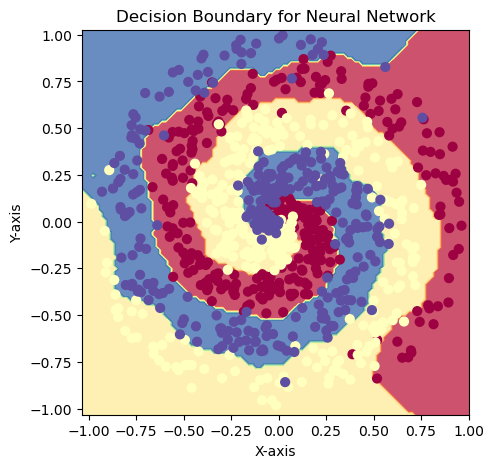

In [14]:
# Plot the decision boundary
def plot_decision_boundary_nn(X, y, model):
    h = 0.02
    x_min, x_max = X[:, 0].min() - .05, X[:, 0].max() + .05
    y_min, y_max = X[:, 1].min() - .05, X[:, 1].max() + .05
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, h), 
        np.arange(y_min, y_max, h)
    )
    mesh_data = np.c_[xx.ravel(), yy.ravel()]
    
    # neural network model prediction
    Z = model(torch.from_numpy(mesh_data).float())
    Z = torch.argmax(Z, 1)
    Z = Z.numpy()
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(5, 5))
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("Decision Boundary for Neural Network")
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.show()

plot_decision_boundary_nn(X, y, model)


## Use Attention

由于我们的数据量不算太大，试一下直接做注意力会怎么样

In [27]:
def show_attention(attention):
    """
    画出注意力权重图

    Parameters
    ----------
    @param attention: torch.Tensor
        attention weights, shape (m, n)
    """

    fig = plt.figure(figsize=(15, 5))

    pcm = plt.imshow(
        attention.detach().numpy(), 
        cmap='Reds'
    )

    plt.xlabel('Key points')
    plt.ylabel('Query points')
    plt.title('Attention weights')
    fig.colorbar(pcm, shrink=0.7)
    plt.show()

In [19]:
X_test.shape, X_train.shape, y_train.shape # q, k, v

(torch.Size([180, 2]), torch.Size([720, 2]), torch.Size([720]))

## Gaussian Kernel Attention

In [21]:
import torch.nn.functional as F
# 汇总上面的操作，我们可以得出一个多元注意力回归的例子
def attention_Gaussian(queries, keys):
    """
    多元注意力回归

    Parameters
    ----------
    @param queries: torch.Tensor
        queries, shape (m, d)
    @param keys: torch.Tensor
        keys, shape (n, d)
    @returns: torch.Tensor
        attention_weights, shape (m, n)
    """
    d = queries.shape[-1]
    m = queries.shape[0]
    n = keys.shape[0]

    dists = queries.reshape(m, 1, d) - keys.reshape(1, n, d)
    dists = dists.square().sum(axis=2)

    return F.softmax(
        -1 * dists.to(torch.float32), 
        dim=1
    )

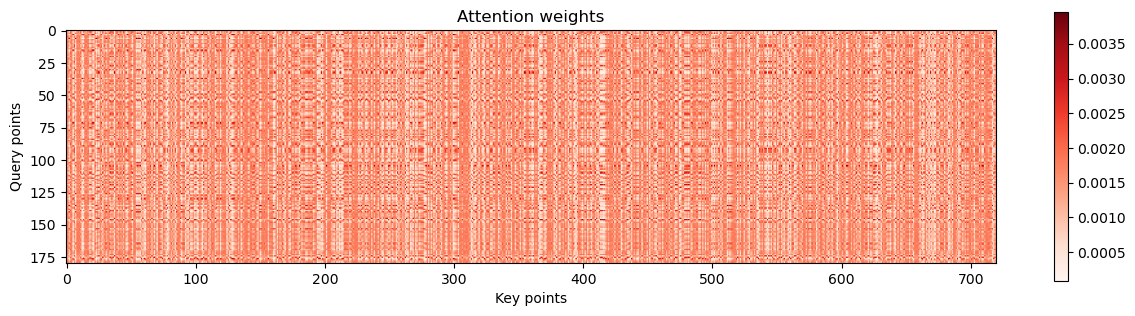

In [29]:
attention_GS = attention_Gaussian(
    queries = X_test, 
    keys = X_train
)
show_attention(
    attention_GS
)

In [45]:
y_one_hot = F.one_hot(y_train, n_classes).float()
y_pred_vec_GS = torch.matmul(attention_GS, y_one_hot)
y_pred_label_GS = torch.argmax(y_pred_vec_GS, 1)
accuracy = accuracy_score(y_test, y_pred_label_GS)
print(f'Test Accuracy: {accuracy * 100:.2f}%') 

Test Accuracy: 28.89%


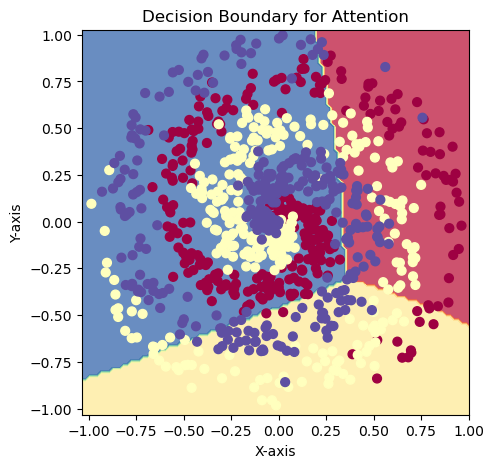

In [47]:
# Plot the decision boundary
def plot_decision_boundary_attention(
        X, y, 
        attention_Func = attention_Gaussian
    ):
    h = 0.02
    x_min, x_max = X[:, 0].min() - .05, X[:, 0].max() + .05
    y_min, y_max = X[:, 1].min() - .05, X[:, 1].max() + .05
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, h), 
        np.arange(y_min, y_max, h)
    )
    mesh_data = np.c_[xx.ravel(), yy.ravel()]
    mesh_data = torch.from_numpy(mesh_data).float()
    
    # attention prediction
    Z = attention_Func(mesh_data, X_train)
    Z = torch.matmul(Z, y_one_hot)
    Z = torch.argmax(Z, 1)
    Z = Z.numpy()
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(5, 5))
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("Decision Boundary for Attention")
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.show()

plot_decision_boundary_attention(X, y)


## Dot Product Attention

In [38]:
def attention_DotProduct(queries, keys):
    """
    多元注意力回归

    Parameters
    ----------
    @param queries: torch.Tensor
        queries, shape (m, d)
    @param keys: torch.Tensor
        keys, shape (n, d)
    @returns: torch.Tensor
        attention_weights, shape (m, n)
    """
    d = queries.shape[-1]

    return F.softmax(
        torch.matmul(
            queries, 
            keys.T
        ).div(
            torch.sqrt(
                torch.tensor(d)
                .to(torch.float32)
            )
        ), 
        dim=1
    )

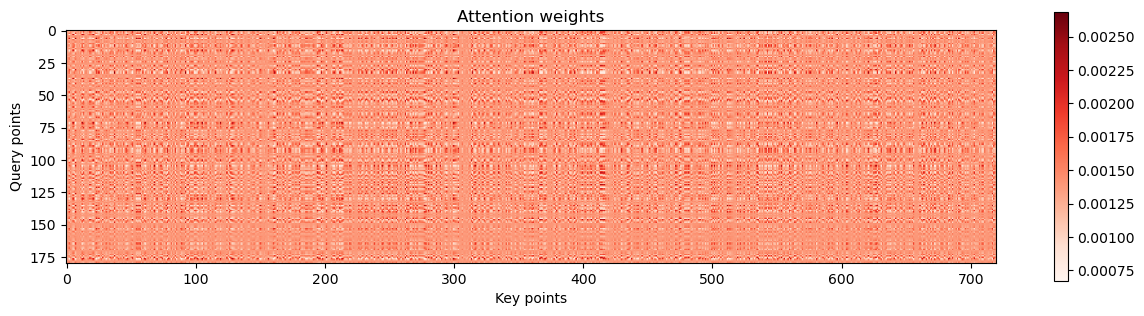

In [39]:
attention_DP = attention_DotProduct(
    queries = X_test, 
    keys = X_train
)
show_attention(
    attention_DP
)

In [48]:
y_one_hot = F.one_hot(y_train, n_classes).float()
y_pred_vec_DP = torch.matmul(attention_DP, y_one_hot)
y_pred_label_DP = torch.argmax(y_pred_vec_DP, 1)
accuracy = accuracy_score(y_test, y_pred_label_DP)
print(f'Test Accuracy: {accuracy * 100:.2f}%') 

Test Accuracy: 30.56%


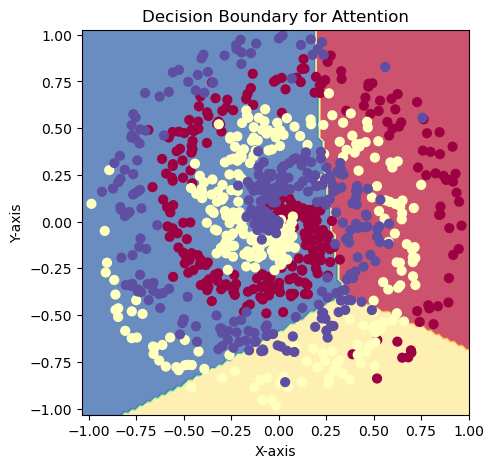

In [49]:
plot_decision_boundary_attention(X, y, attention_DotProduct)

## Summary

这里我们试图通过使用attention机制通过之前的数据来预测下一个点，但是并不好，也可以看到了我们的注意力方法几乎都没有参加过训练，而是直接拿来用的，所以效果不好也是可以理解的。后面我们学习了其它attention score function之后再回来看一下吧。